In [1]:
# Load all the libraries we'll be using
from pomegranate import BayesianNetwork
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs #hehe
from nltk.corpus import stopwords
import re
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
# import dataset
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

In [3]:
def article_to_words(raw_article, remove_stopwords=False):
    #Convert the raw article string to a cleaner version taking the steps below
    #Why? So that sklearn's CountVectorizer will accept the review data as input
    
    #remove HTML
    text = bs(raw_article, "html.parser").get_text()
    
    #remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    
    #convert to lowercase and split into individual words
    words = letters_only.lower().split() 
    
    if remove_stopwords:
        #convert stopwords to a set
        stops = set(stopwords.words("english"))  
    
        #remove stop words
        words = [w for w in words if not w in stops]
    
    #join words back together
    #(this is just a long string of the words in the review)
    return words

In [4]:
article_id_dict = {}
id_article_dict = {}
for i,article in enumerate(train['articleBody'].unique()):

    article_id_dict[article]=i
    id_article_dict[i] = article

headline_id_dict = {}
id_headline_dict = {}
for i,headline in enumerate(train['Headline'].unique()):

    headline_id_dict[headline] = i
    id_headline_dict[i] = headline

article_id_test_dict = {}
id_article_test_dict = {}
for i,article in enumerate(test['articleBody'].unique()):

    article_id_test_dict[article] = i
    id_article_test_dict[i] = article

headline_id_test_dict = {}
id_headline_test_dict = {}
for i,headline in enumerate(test['Headline'].unique()):

    headline_id_test_dict[headline] = i
    id_headline_test_dict[i] = headline

In [5]:
print(len(headline_id_dict.keys()))

1648


In [6]:
# clean the articles up
clean_train_articles = pd.Series(train['articleBody'].unique()).apply(article_to_words, remove_stopwords=True)
clean_test_articles = pd.Series(test['articleBody'].unique()).apply(article_to_words, remove_stopwords=True)
clean_train_headlines = pd.Series(train['Headline'].unique()).apply(article_to_words, remove_stopwords=True)
clean_test_headlines = pd.Series(test['Headline'].unique()).apply(article_to_words, remove_stopwords=True)

In [7]:
print clean_train_articles.shape
print clean_train_headlines.shape
print
print clean_test_articles.shape
print clean_test_headlines.shape

(1649L,)
(1648L,)

(1446L,)
(1589L,)


In [8]:
from gensim.models import ldamodel, tfidfmodel
from gensim.corpora import MmCorpus, Dictionary
num_topics=100

C:\Users\Jake\Anaconda3\envs\BNSL\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
No handlers could be found for logger "gensim.models.doc2vec"


In [9]:
# create dictionaries for tokenization
train_dictionary = Dictionary(clean_train_articles.append(clean_train_headlines))
print(train_dictionary)

Dictionary(22303 unique tokens: [u'inserbia', u'woods', u'spiders', u'francesco', u'woody']...)


In [10]:
# create corpus objects from bag-of-words vectors generated from articles & headlines
train_corpus = [train_dictionary.doc2bow(text) for text in clean_train_articles.append(clean_train_headlines)]
test_corpus = [train_dictionary.doc2bow(text) for text in clean_test_articles.append(clean_test_headlines)]

# save corpuses
MmCorpus.serialize('train_corpus_bow.mm', train_corpus)
MmCorpus.serialize('test_corpus_bow.mm', test_corpus)

In [10]:
# load the corpuses as MmCorpus objects so they'll play nice with the LdaModel
train_mm = MmCorpus('train_corpus_bow.mm')
test_mm = MmCorpus('test_corpus_bow.mm')

In [12]:
# fit the LDA model
lda_model = ldamodel.LdaModel(corpus=train_corpus, id2word=train_dictionary, num_topics=num_topics,
                              update_every=1, chunksize=10, passes=2)

In [13]:
# print the top 10 words for each topic
topics = lda_model.show_topics(100)
for topic,eq in topics:
    words = re.findall(pattern='"([A-Za-z]+)"',string=eq)
    print('topic #',topic,':', ", ".join(words))

('topic #', 0, ':', u'may, get, says, february, fire, plans, currently, market, choosing, mortar')
('topic #', 1, ':', u'infected, sister, unlucky, hospital, dallas, cut, girlfriend, doctors, fed, symptoms')
('topic #', 2, ':', u'steve, tears, student, panel, culkin, macaulay, christian, star, porn, fox')
('topic #', 3, ':', u'proposal, fireworks, stomach, unannounced, sports, romantic, hopeless, offices, unluckiest, diagnostics')
('topic #', 4, ':', u'busy, pulls, lin, paler, prankster, anyway, serial, beggar, makeover, buys')
('topic #', 5, ':', u'baby, woman, son, feminist, aborted, female, joy, forever, pregnant, aborts')
('topic #', 6, ':', u'north, source, culture, cheese, concubine, senseless, booming, landfill, mistress, gallery')
('topic #', 7, ':', u'play, platinum, launching, start, fear, mean, secure, luxury, wfb, blasts')
('topic #', 8, ':', u'valley, burns, wants, israel, hires, israeli, followers, robocops, dalek, able')
('topic #', 9, ':', u'hostage, plea, prof, jihadi,

In [14]:
# create design matrix for training data
X_train_articles = np.zeros((len(clean_train_articles),num_topics),dtype='float32')
for i in range(len(clean_train_articles)):
    text = clean_train_articles[i]
    bow_vec = train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_train_articles[i,col] = weight

In [15]:
# create design matrix for training data
X_train_headlines = np.zeros((len(clean_train_headlines),num_topics),dtype='float32')
for i in range(len(clean_train_headlines)):
    text = clean_train_headlines[i]
    bow_vec = train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_train_headlines[i,col] = weight

In [16]:
X_test_articles = np.zeros((len(clean_test_articles),num_topics),dtype='float32')
for i in range(len(clean_test_articles)):
    text = clean_test_articles[i]
    bow_vec = train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_test_articles[i,col] = weight

In [17]:
# create design matrix for training data
X_test_headlines = np.zeros((len(clean_test_headlines),num_topics),dtype='float32')
for i in range(len(clean_test_headlines)):
    text = clean_test_headlines[i]
    bow_vec = train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_test_headlines[i,col] = weight

In [18]:
print X_train_headlines.shape
print X_train_articles.shape
print X_test_headlines.shape
print X_test_articles.shape

(1648L, 100L)
(1649L, 100L)
(1589L, 100L)
(1446L, 100L)


In [17]:
X_train_all = np.append(X_train_articles,X_train_headlines,axis=0)

In [19]:
print( X_train_all.shape)
X_train_small = X_train_all[:1000,:]
print(X_train_small)

(3297L, 100L)
[[ 0.          0.          0.         ...,  0.01138836  0.01712001  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.64125735 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.04406986  0.          0.01813764 ...,  0.01226934  0.          0.01273272]
 [ 0.          0.01792552  0.         ...,  0.          0.01806228  0.        ]]


In [15]:
np.random.seed(14)
np.random.shuffle(X_train_articles)
print(X_train_articles[:100])

[[ 0.          0.01231801  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.11111032  0.01212106 ...,  0.          0.          0.02291369]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.20239058
   0.02593388]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [19]:
model = BayesianNetwork.from_samples(X_train_articles[:600])
print model.structure

((), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (82,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (82,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (82,), (53,), (53,), (0,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,), (53,))


In [20]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)


C:\Users\Jake\Anaconda3\envs\BNSL\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\Jake\Anaconda3\envs\BNSL\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\Jake\Anaconda3\envs\BNSL\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Jake\Anaconda3\envs\BNSL\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

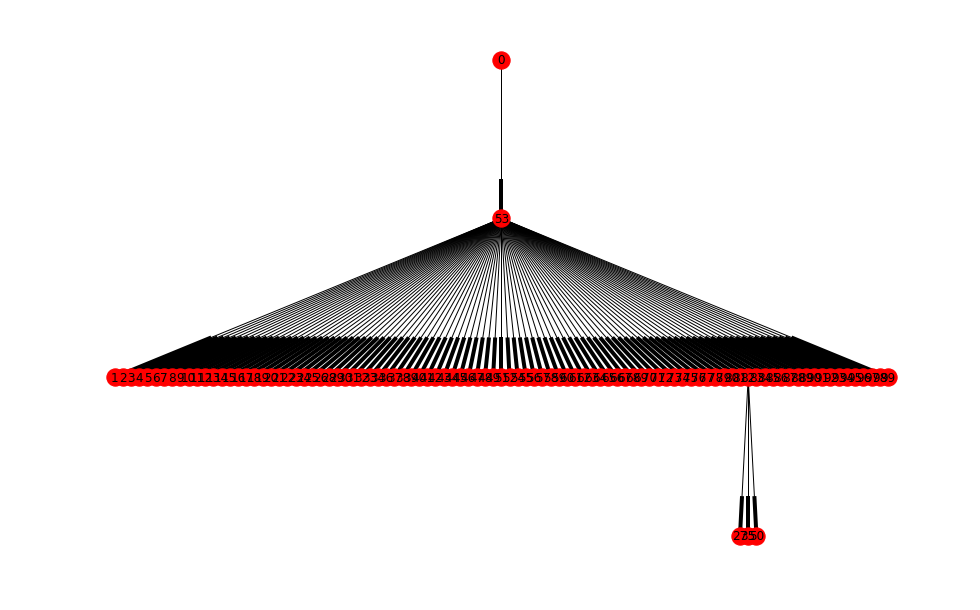

In [21]:

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(13,8))
nx.draw(G, pos, with_labels=True, k=1)
plt.show()
plt.savefig('test.png')

In [21]:
model = BayesianNetwork.from_samples(X_train_articles[:600], root=33)
print model.structure

((38,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (38,), (33,), (33,), (33,), (38,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (38,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (38,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,), (33,))


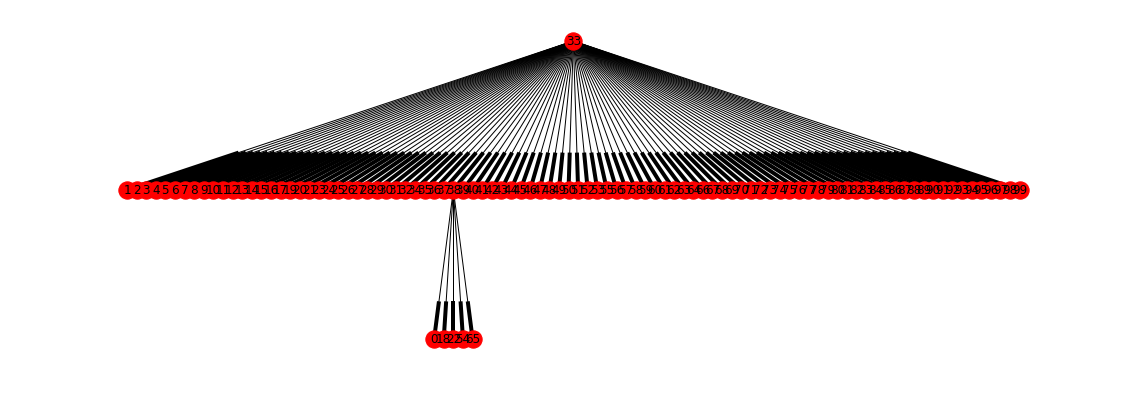

In [22]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.savefig('testing.png', bbox_inches='tight')
plt.show()


In [ ]:
general_topics = [13,67]

In [22]:
X_train_headlines1 = np.delete(X_train_headlines,53,axis=1)
X_train_articles1 = np.delete(X_train_articles,53,axis=1)
X_test_headlines1 = np.delete(X_test_headlines,53,axis=1)
X_test_articles1 = np.delete(X_test_articles,53,axis=1)

In [24]:
X_train_headlines2 = np.delete(X_train_headlines1,33,axis=1)
X_train_articles2 = np.delete(X_train_articles1,33,axis=1)
X_test_headlines2 = np.delete(X_test_headlines1,33,axis=1)
X_test_articles2 = np.delete(X_test_articles1,33,axis=1)

In [23]:
X_train_headlines2 = X_train_headlines1
X_train_articles2 = X_train_articles1
X_test_headlines2 = X_test_headlines1
X_test_articles2 = X_test_articles1

In [24]:
model = BayesianNetwork.from_samples(X_train_articles2[:500])
print model.structure

((), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (54,), (81,), (81,), (81,), (81,), (54,), (81,), (81,), (81,), (81,), (81,), (81,), (54,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (54,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (54,), (81,), (81,), (81,), (81,), (81,), (0,), (81,), (81,), (54,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,), (81,))


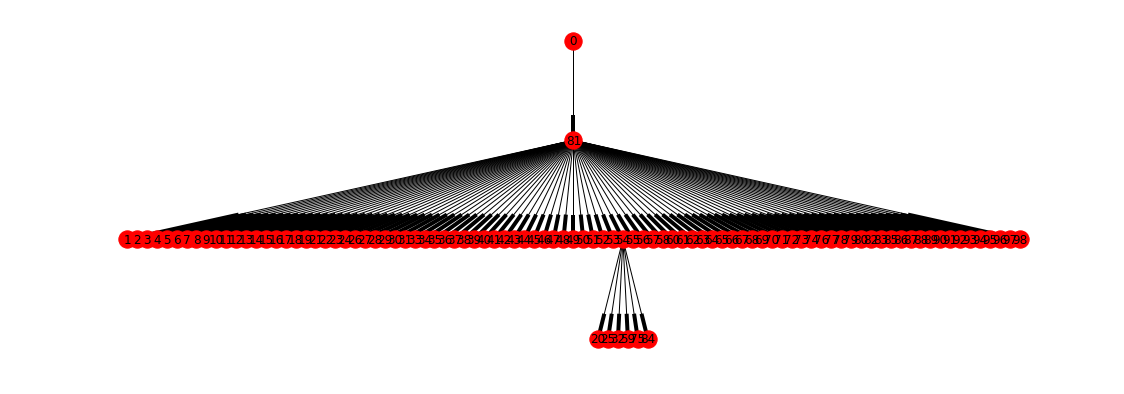

In [25]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.savefig('testing.png', bbox_inches='tight')
plt.show()

In [26]:
X_train_headlines3 = np.delete(X_train_headlines2,81,axis=1)
X_train_articles3 = np.delete(X_train_articles2,81,axis=1)
X_test_headlines3 = np.delete(X_test_headlines2,81,axis=1)
X_test_articles3 = np.delete(X_test_articles2,81,axis=1)

In [27]:
model = BayesianNetwork.from_samples(X_train_articles3[:500])
print model.structure

((), (54,), (54,), (54,), (46,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (46,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (46,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (0,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (44,), (54,), (46,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (46,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,), (54,))


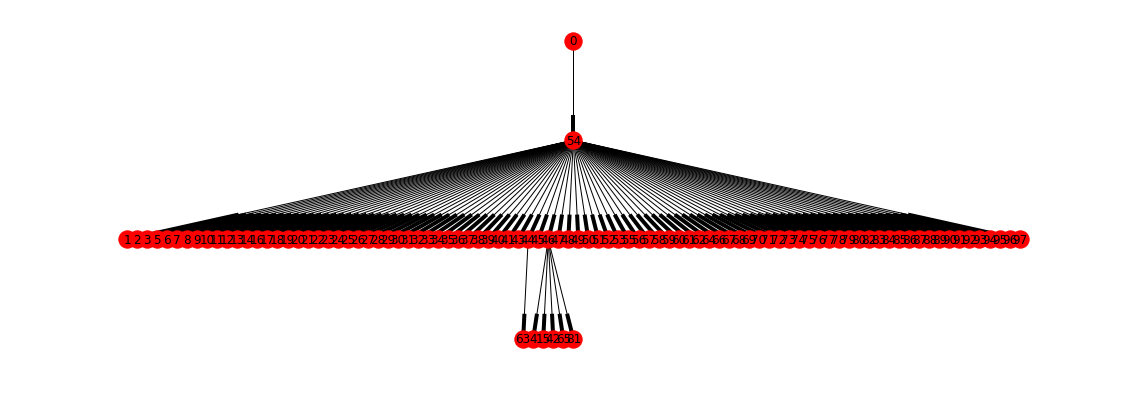

In [29]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.savefig('testing.png', bbox_inches='tight')
plt.show()

In [30]:
X_train_headlines4 = np.delete(X_train_headlines3,54,axis=1)
X_train_articles4 = np.delete(X_train_articles3,54,axis=1)
X_test_headlines4 = np.delete(X_test_headlines3,54,axis=1)
X_test_articles4 = np.delete(X_test_articles3,54,axis=1)

In [31]:
model = BayesianNetwork.from_samples(X_train_articles4[:500])
print model.structure

((), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (32,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (32,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (0,), (46,), (46,), (46,), (46,), (32,), (44,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (19,), (46,), (46,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,))


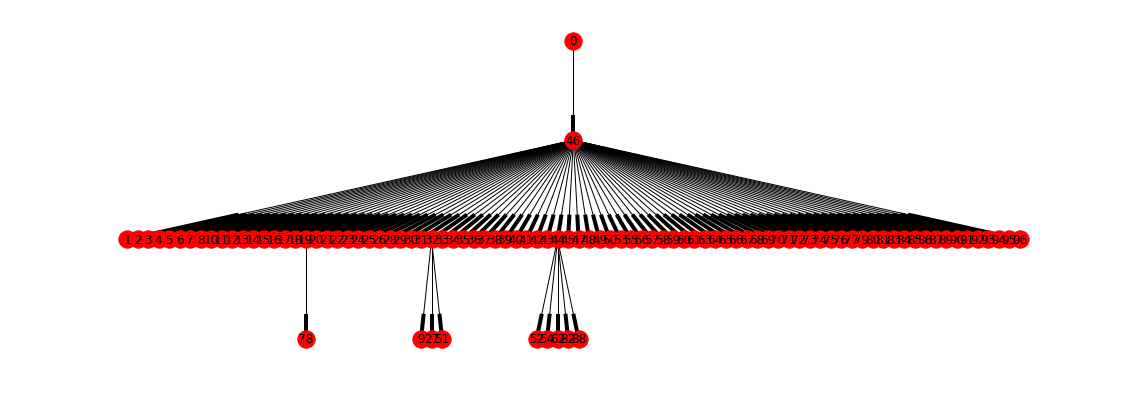

In [32]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.savefig('testing.png', bbox_inches='tight')
plt.show()

In [33]:
model = BayesianNetwork.from_samples(X_train_articles4[:500], root=46)
print model.structure

((46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (32,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (32,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (), (46,), (46,), (46,), (46,), (32,), (44,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (19,), (46,), (46,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (44,), (46,), (46,), (46,), (46,), (46,), (46,), (46,), (46,))


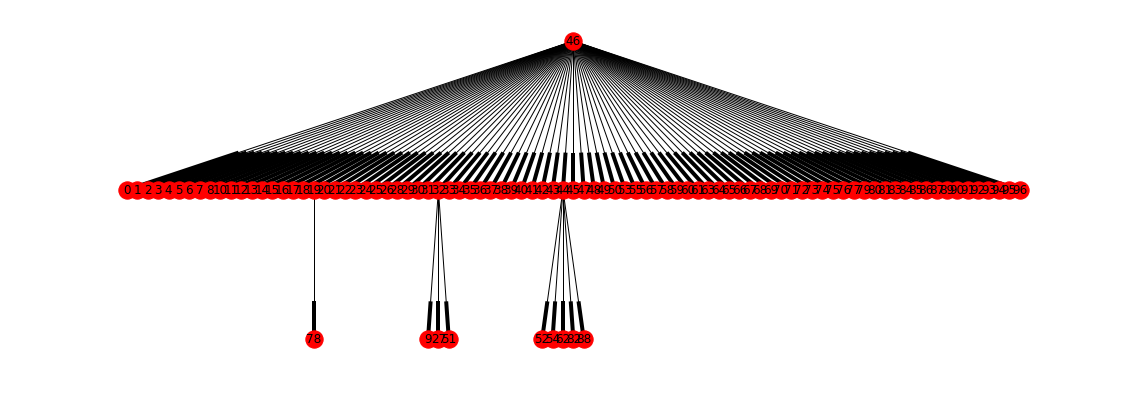

In [34]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.savefig('testing.png', bbox_inches='tight')
plt.show()

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [36]:
# sim scores after removing general topics
related_sim_scores = []
unrelated_sim_scores = []
for index,row in train.iterrows():
    article = row['articleBody']
    headline = row['Headline']
    
    article_idx = article_id_dict[article]
    headline_idx = headline_id_dict[headline]
    
    article_vec = X_train_articles4[article_idx,:]
    headline_vec = X_train_headlines4[headline_idx,:]
    
    stance = row['Stance']
    if stance != 'unrelated':
        stance_i = 1
    else:
        stance_i = 0
    sim_score = cosine_similarity(article_vec.reshape(1,-1),headline_vec.reshape(1,-1))[0][0]
    if stance_i == 0:
        unrelated_sim_scores.append(sim_score)
    else:
        related_sim_scores.append(sim_score)
    
    

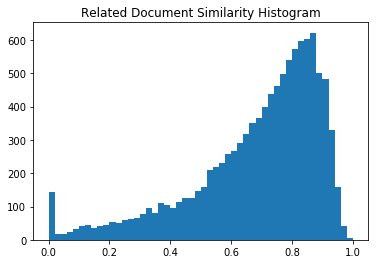

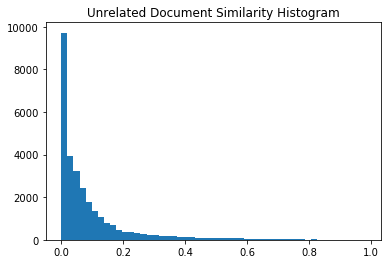

In [37]:
n, bins, patches = plt.hist(related_sim_scores, 50)
plt.title('Related Document Similarity Histogram')
plt.savefig('Related_sim_hist.png')
plt.show()
n, bins, patches = plt.hist(unrelated_sim_scores, 50)
plt.title('Unrelated Document Similarity Histogram')
plt.savefig('Unrelated_sim_hist.png')
plt.show()

In [38]:
# sim scores before removing general topics
related_sim_scores_before = []
unrelated_sim_scores_before = []
for index,row in train.iterrows():
    article = row['articleBody']
    headline = row['Headline']
    
    article_idx = article_id_dict[article]
    headline_idx = headline_id_dict[headline]
    
    article_vec = X_train_articles[article_idx,:]
    headline_vec = X_train_headlines[headline_idx,:]
    
    stance = row['Stance']
    if stance != 'unrelated':
        stance_i = 1
    else:
        stance_i = 0
    sim_score = cosine_similarity(article_vec.reshape(1,-1),headline_vec.reshape(1,-1))[0][0]
    if stance_i == 0:
        unrelated_sim_scores_before.append(sim_score)
    else:
        related_sim_scores_before.append(sim_score)

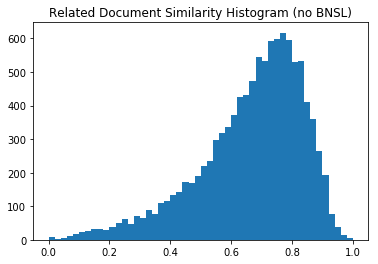

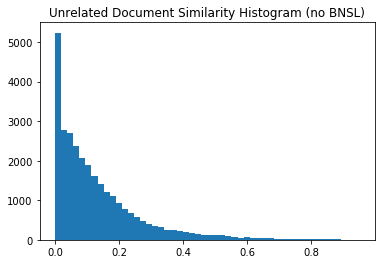

In [39]:
n, bins, patches = plt.hist(related_sim_scores_before, 50)
plt.title('Related Document Similarity Histogram (no BNSL)')
plt.savefig('Related_doc_sim_hist_noBNSL.png')
plt.show()
n, bins, patches = plt.hist(unrelated_sim_scores_before, 50)
plt.title('Unrelated Document Similarity Histogram (no BNSL)')
plt.savefig('Unrelated_doc_sim_hist_noBNSL.png')
plt.show()

In [40]:
from sklearn.neighbors import KernelDensity

In [41]:
kernel_pos = KernelDensity(bandwidth=0.06)
kernel_neg = KernelDensity(bandwidth=0.06)

kernel_pos.fit(np.asarray(related_sim_scores).reshape(-1,1))
kernel_neg.fit(np.asarray(unrelated_sim_scores).reshape(-1,1))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.06, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [42]:
kernel_pos_before = KernelDensity(bandwidth=0.06)
kernel_neg_before = KernelDensity(bandwidth=0.06)

kernel_pos_before.fit(np.asarray(related_sim_scores_before).reshape(-1,1))
kernel_neg_before.fit(np.asarray(unrelated_sim_scores_before).reshape(-1,1))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.06, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

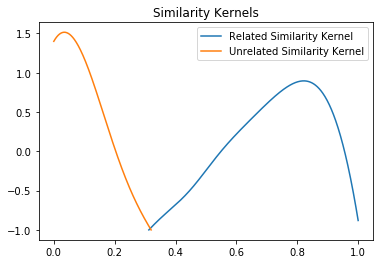

In [43]:
x = np.linspace(0.0,1,1000)
y = kernel_pos.score_samples(x.reshape(-1,1))
x = x[ y>-1 ]
y = y[ y>-1 ]
plt.plot(x,y, label='Related Similarity Kernel')
x = np.linspace(0.0,0.9,1000)
y = kernel_neg.score_samples(x.reshape(-1,1))
x = x[ y>-1 ]
y = y[ y>-1 ]
plt.plot(x,y, label='Unrelated Similarity Kernel')
plt.legend(loc='upper right')
plt.title('Similarity Kernels')
plt.savefig('sim_kernels.png')
plt.show()

In [44]:
y_hat = []
pos_probs = []
related_headlines = []
related_articles = []
related_stances = []
for index,row in test.iterrows():
    article = row['articleBody']
    headline = row['Headline']
    stance = row['Stance']
    
    article_idx = article_id_test_dict[article]
    headline_idx = headline_id_test_dict[headline]
    
    article_vec = X_test_articles2[article_idx,:]
    headline_vec = X_test_headlines2[headline_idx,:]
    
    sim_score = cosine_similarity(article_vec.reshape(1,-1),headline_vec.reshape(1,-1))[0][0]
    
    pos_prob = kernel_pos.score_samples(sim_score)
    neg_prob = kernel_neg.score_samples(sim_score)
    
    pos_probs.append(pos_prob)
    
    if pos_prob >= neg_prob:
        y_hat_i = 1
        related_headlines.append(headline)
        related_articles.append(article)
        related_stances.append(stance)
    else:
        y_hat_i = 0
    y_hat.append(y_hat_i)
    
    

In [45]:
y_hat_before = []
pos_probs_before = []
for index,row in test.iterrows():
    article = row['articleBody']
    headline = row['Headline']
    
    article_idx = article_id_test_dict[article]
    headline_idx = headline_id_test_dict[headline]
    
    article_vec = X_test_articles[article_idx,:]
    headline_vec = X_test_headlines[headline_idx,:]
    
    sim_score = cosine_similarity(article_vec.reshape(1,-1),headline_vec.reshape(1,-1))[0][0]
    
    pos_prob = kernel_pos.score_samples(sim_score)
    neg_prob = kernel_neg.score_samples(sim_score)
    
    pos_probs_before.append(pos_prob)
    
    if pos_prob >= neg_prob:
        y_hat_i = 1
    else:
        y_hat_i = 0
    y_hat_before.append(y_hat_i)

In [46]:
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [47]:

new_train_X = []
new_train_Y = []
for index,row in train.iterrows():
    article = row['articleBody']
    headline = row['Headline']
    
    article_idx = article_id_dict[article]
    headline_idx = headline_id_dict[headline]
    
    article_vec = X_train_articles2[article_idx,:]
    headline_vec = X_train_headlines2[headline_idx,:]
    
    both = np.append(article_vec,[-1])
    both = np.append(both,headline_vec)
    new_train_X.append(both)
    
    stance = row['Stance']
    if stance != 'unrelated':
        stance_i = 1
    else:
        stance_i = 0
    new_train_Y.append(stance_i)
    

In [48]:


new_test_X = []
new_test_Y = []
for index,row in test.iterrows():
    article = row['articleBody']
    headline = row['Headline']
    
    article_idx = article_id_test_dict[article]
    headline_idx = headline_id_test_dict[headline]
    
    article_vec = X_test_articles2[article_idx,:]
    headline_vec = X_test_headlines2[headline_idx,:]
    
    both = np.append(article_vec,[-1])
    both = np.append(both,headline_vec)
    new_test_X.append(both)
    
    stance = row['Stance']
    if stance != 'unrelated':
        stance_i = 1
    else:
        stance_i = 0
    new_test_Y.append(stance_i)
    

In [49]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, accuracy_score

[[6713  651]
 [ 120 2583]]
0.923413132015


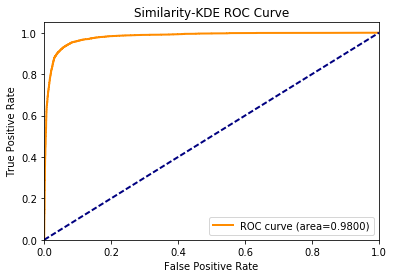

In [50]:
print confusion_matrix(new_test_Y,y_hat)
print accuracy_score(new_test_Y,y_hat)
fpr, tpr, _ = roc_curve(new_test_Y,pos_probs)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC curve (area=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Similarity-KDE ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc-auc-with-BNSL.png')
plt.show()

In [51]:
test['LDA-BNSL-KDE label'] = y_hat

In [52]:
test.to_csv('LDA-BNSL-KDE_label.csv', index=False)

[[6617  747]
 [ 116 2587]]
0.914274361776


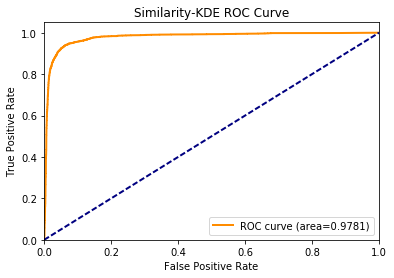

In [53]:
print confusion_matrix(new_test_Y,y_hat_before)
print accuracy_score(new_test_Y,y_hat_before)
fpr, tpr, _ = roc_curve(new_test_Y,pos_probs_before)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC curve (area=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Similarity-KDE ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc-auc-without-BNSL.png', bbox_inches='tight')
plt.show()

In [59]:
related_train = train[ train['Stance'] != 'unrelated' ]

In [61]:


# clean the articles up
clean_related_train_articles = pd.Series(related_train['articleBody'].unique()).apply(article_to_words, remove_stopwords=True)
clean_related_train_headlines = pd.Series(related_train['Headline'].unique()).apply(article_to_words, remove_stopwords=True)
clean_related_test_articles = pd.Series(pd.Series(related_articles).unique()).apply(article_to_words, remove_stopwords=True)
clean_related_test_headlines = pd.Series(pd.Series(related_headlines).unique()).apply(article_to_words, remove_stopwords=True)


In [68]:
# create dictionaries for tokenization
related_train_dictionary = Dictionary(clean_related_train_articles.append(clean_related_train_headlines))
print(related_train_dictionary)

Dictionary(22135 unique tokens: [u'inserbia', u'woods', u'spiders', u'francesco', u'woody']...)


In [69]:
# create corpus objects from bag-of-words vectors generated from articles & headlines
related_train_corpus = [related_train_dictionary.doc2bow(text) for text in clean_related_train_articles.append(clean_related_train_headlines)]
related_test_corpus = [related_train_dictionary.doc2bow(text) for text in clean_related_test_articles.append(clean_related_test_headlines)]

In [72]:
# fit the LDA model
related_lda_model = ldamodel.LdaModel(corpus=related_train_corpus, id2word=related_train_dictionary, num_topics=num_topics,
                              update_every=1, chunksize=10, passes=2)

In [73]:
# print the top 10 words for each topic
topics = related_lda_model.show_topics(100)
for topic,eq in topics:
    words = re.findall(pattern='"([A-Za-z]+)"',string=eq)
    print('topic #',topic,':', ", ".join(words))

('topic #', 0, ':', u'scotland, suspect, beatles, named, doubt, makes, charges, beginning, unconfirmed, prison')
('topic #', 1, ':', u'amid, blurred, blur, quit, epic, rebuffs, drug, dime, ticket, try')
('topic #', 2, ':', u'school, house, bosnian, needs, parental, abducted, bosnia, herzegovina, furious, yfpaspv')
('topic #', 3, ':', u'nasa, center, coming, find, caused, event, triggers, evidence, website, lady')
('topic #', 4, ':', u'missing, jetliners, attacks, libyan, airliner, grave, flower, takeover, pits, behead')
('topic #', 5, ':', u'truce, source, great, members, despite, gunned, book, told, unverified, due')
('topic #', 6, ':', u'reports, ebola, city, airport, dallas, scary, fears, homophobe, erroneous, bag')
('topic #', 7, ':', u'twitter, basher, hand, part, right, recognized, com, popwatch, shortlands, suspiciously')
('topic #', 8, ':', u'saudi, michelle, bugatti, christmas, photo, moment, present, banning, gave, heated')
('topic #', 9, ':', u'rescue, boss, une, que, tre, d

In [74]:
# create design matrix for training data
X_train_articles = np.zeros((len(clean_related_train_articles),num_topics),dtype='float32')
for i in range(len(clean_related_train_articles)):
    text = clean_related_train_articles[i]
    bow_vec = related_train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = related_lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_train_articles[i,col] = weight

In [75]:
# create design matrix for training data
X_train_headlines = np.zeros((len(clean_related_train_headlines),num_topics),dtype='float32')
for i in range(len(clean_related_train_headlines)):
    text = clean_related_train_headlines[i]
    bow_vec = related_train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = related_lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_train_headlines[i,col] = weight

In [76]:
X_test_articles = np.zeros((len(clean_related_test_articles),num_topics),dtype='float32')
for i in range(len(clean_related_test_articles)):
    text = clean_related_test_articles[i]
    bow_vec = related_train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = related_lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_test_articles[i,col] = weight

In [77]:
# create design matrix for testing data
X_test_headlines = np.zeros((len(clean_related_test_headlines),num_topics),dtype='float32')
for i in range(len(clean_related_test_headlines)):
    text = clean_related_test_headlines[i]
    bow_vec = related_train_dictionary.doc2bow(text) # create bag-of-words vector
    topic_weights = related_lda_model[bow_vec]
    for dist in topic_weights:
        col=dist[0]
        weight=dist[1]
        X_test_headlines[i,col] = weight

In [78]:
model = BayesianNetwork.from_samples(X_train_articles[:500])
print model.structure

((), (15,), (63,), (63,), (63,), (63,), (15,), (15,), (15,), (63,), (15,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (15,), (15,), (63,), (63,), (63,), (63,), (63,), (15,), (15,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (15,), (63,), (63,), (63,), (63,), (63,), (15,), (63,), (15,), (63,), (63,), (63,), (63,), (15,), (15,), (63,), (63,), (63,), (63,), (63,), (63,), (15,), (63,), (63,), (63,), (63,), (63,), (0,), (63,), (63,), (15,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (63,), (15,), (63,), (63,), (63,), (63,), (63,), (3,), (63,))


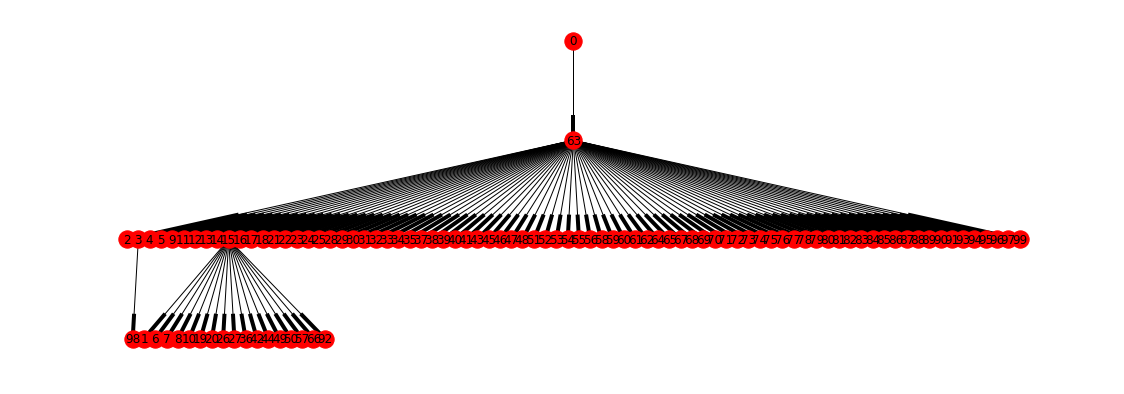

In [79]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.show()


In [80]:
X_train_headlines1 = np.delete(X_train_headlines,63,axis=1)
X_train_articles1 = np.delete(X_train_articles,63,axis=1)
X_test_headlines1 = np.delete(X_test_headlines,63,axis=1)
X_test_articles1 = np.delete(X_test_articles,63,axis=1)

In [81]:
X_train_headlines2 = np.delete(X_train_headlines1,15,axis=1)
X_train_articles2 = np.delete(X_train_articles1,15,axis=1)
X_test_headlines2 = np.delete(X_test_headlines1,15,axis=1)
X_test_articles2 = np.delete(X_test_articles1,15,axis=1)

In [87]:
print(X_train_headlines2.shape)
print(X_train_articles2.shape)

(1606L, 98L)
(1621L, 98L)


In [82]:
model = BayesianNetwork.from_samples(X_train_articles2[:500])
print model.structure

((), (3,), (3,), (0,), (83,), (3,), (3,), (3,), (37,), (3,), (3,), (3,), (3,), (37,), (3,), (3,), (3,), (3,), (37,), (3,), (3,), (3,), (37,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (42,), (3,), (3,), (3,), (3,), (37,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (15,), (3,), (3,), (3,), (3,), (3,), (37,), (46,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (46,), (3,), (37,), (3,), (3,), (37,), (3,), (37,), (3,), (3,), (3,), (3,), (3,), (3,), (37,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (37,), (3,), (3,), (46,), (3,), (3,), (3,), (3,), (3,))


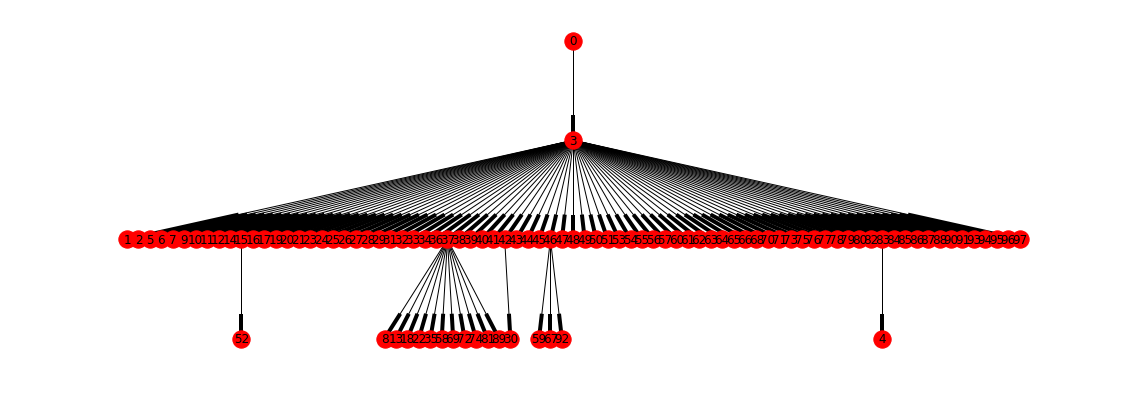

In [83]:
G = nx.DiGraph()
G_dict = {}
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)
            

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
plt.figure(figsize=(15,5))
nx.draw(G, pos, with_labels=True)
plt.show()


In [93]:
print(X_train_headlines2.shape)

(1606L, 98L)


In [110]:
related_article_id_dict = {}
related_id_article_dict = {}
for i,article in enumerate(related_train['articleBody'].unique()):
    related_article_id_dict[article]=i
    related_id_article_dict[i] = article

related_headline_id_dict = {}
related_id_headline_dict = {}
for i,headline in enumerate(related_train['Headline'].unique()):
    related_headline_id_dict[headline] = i
    related_id_headline_dict[i] = headline



In [111]:
print(len(related_id_article_dict.keys()))
print(len(related_id_headline_dict.keys()))

1621
1606


In [113]:
# sim scores after removing general topics
agree_sim_scores = []
disagree_sim_scores = []
discuss_sim_scores = []
for index,row in related_train.iterrows():

    article = row['articleBody']
    headline = row['Headline']
    
    article_idx = related_article_id_dict[article]
    headline_idx = related_headline_id_dict[headline]
    
    article_vec = X_train_articles2[article_idx,:]
    headline_vec = X_train_headlines2[headline_idx,:]
    
    stance = row['Stance']
    sim_score = cosine_similarity(article_vec.reshape(1,-1),headline_vec.reshape(1,-1))[0][0]
    
    if stance == 'agree':
        agree_sim_scores.append(sim_score)
    elif stance == 'disagree':
        disagree_sim_scores.append(sim_score)
    elif stance == 'discuss':
        discuss_sim_scores.append(sim_score)
        
    
    

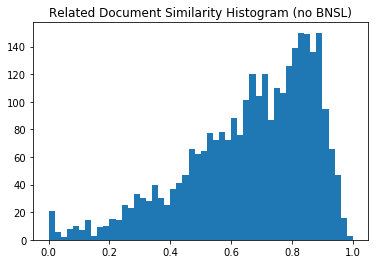

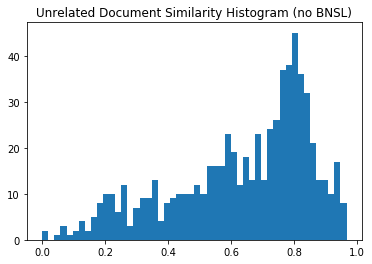

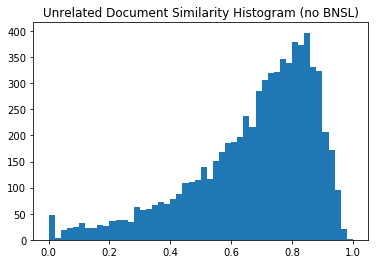

In [116]:
n, bins, patches = plt.hist(agree_sim_scores, 50)
plt.title('Related Document Similarity Histogram (no BNSL)')
plt.savefig('Related_doc_sim_hist_noBNSL.png')
plt.show()
n, bins, patches = plt.hist(disagree_sim_scores, 50)
plt.title('Unrelated Document Similarity Histogram (no BNSL)')
plt.savefig('Unrelated_doc_sim_hist_noBNSL.png')
plt.show()
n, bins, patches = plt.hist(discuss_sim_scores, 50)
plt.title('Unrelated Document Similarity Histogram (no BNSL)')
plt.savefig('Unrelated_doc_sim_hist_noBNSL.png')
plt.show()


In [74]:
clf = LinearSVC(class_weight='balanced')
clf.fit(new_train_X,new_train_Y)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [ ]:
clf = SVC(class_weight='balanced')
clf.fit(new_train_X,new_train_Y)

In [ ]:
y_hat = clf.predict(new_test_X)

In [ ]:
from sklearn.metrics import auc, roc_curve, confusion_matrix

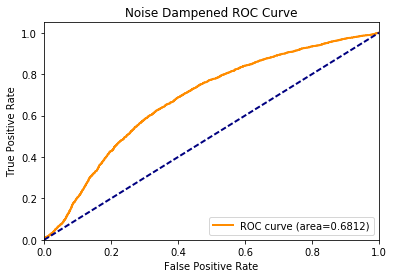

In [77]:
conf_scores = clf.decision_function(new_test_X)
fpr, tpr, _ = roc_curve(new_test_Y,conf_scores)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC curve (area=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Noise Dampened ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
X_train_articles.tofile('X_train_articles.csv',sep=',')
X_train_headlines.tofile('X_train_headlines.csv',sep=',')
X_test_articles.tofile('X_test_articles.csv',sep=',')
X_test_headlines.tofile('X_test_headlines.csv',sep=',')

In [32]:
X_train_articles.shape

(1649L, 100L)

In [24]:
X_train_articles = np.delete(X_train_articles,31, axis=1)
X_train_headlines = np.delete(X_train_headlines,31, axis=1)

In [25]:
np.random.shuffle(X_train_articles)

(1649L, 99L)

In [29]:
model = BayesianNetwork.from_samples(X_train_articles[:600], root=56)
print model.structure

((56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,), (56,))


In [31]:
G = nx.DiGraph()
G_dict = {}

In [32]:
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)




{0: (27.0, 18.0), 1: (99.0, 18.0), 2: (171.0, 18.0), 3: (243.0, 18.0), 4: (315.0, 18.0), 5: (387.0, 18.0), 6: (459.0, 18.0), 7: (531.0, 18.0), 8: (603.0, 18.0), 9: (675.0, 18.0), 10: (747.0, 18.0), 11: (819.0, 18.0), 12: (891.0, 18.0), 13: (963.0, 18.0), 14: (1035.0, 18.0), 15: (1107.0, 18.0), 16: (1179.0, 18.0), 17: (1251.0, 18.0), 18: (1323.0, 18.0), 19: (1395.0, 18.0), 20: (1467.0, 18.0), 21: (1539.0, 18.0), 22: (1611.0, 18.0), 23: (1683.0, 18.0), 24: (1755.0, 18.0), 25: (1827.0, 18.0), 26: (1899.0, 18.0), 27: (1971.0, 18.0), 28: (2043.0, 18.0), 29: (2115.0, 18.0), 30: (2187.0, 18.0), 31: (2259.0, 18.0), 32: (2331.0, 18.0), 33: (2403.0, 18.0), 34: (2475.0, 18.0), 35: (2547.0, 18.0), 36: (2619.0, 18.0), 37: (2691.0, 18.0), 38: (2763.0, 18.0), 39: (2835.0, 18.0), 40: (2907.0, 18.0), 41: (2979.0, 18.0), 42: (3051.0, 18.0), 43: (3123.0, 18.0), 44: (3195.0, 18.0), 45: (3267.0, 18.0), 46: (3339.0, 18.0), 47: (3411.0, 18.0), 48: (3483.0, 18.0), 49: (3555.0, 18.0), 50: (3627.0, 18.0), 51: (

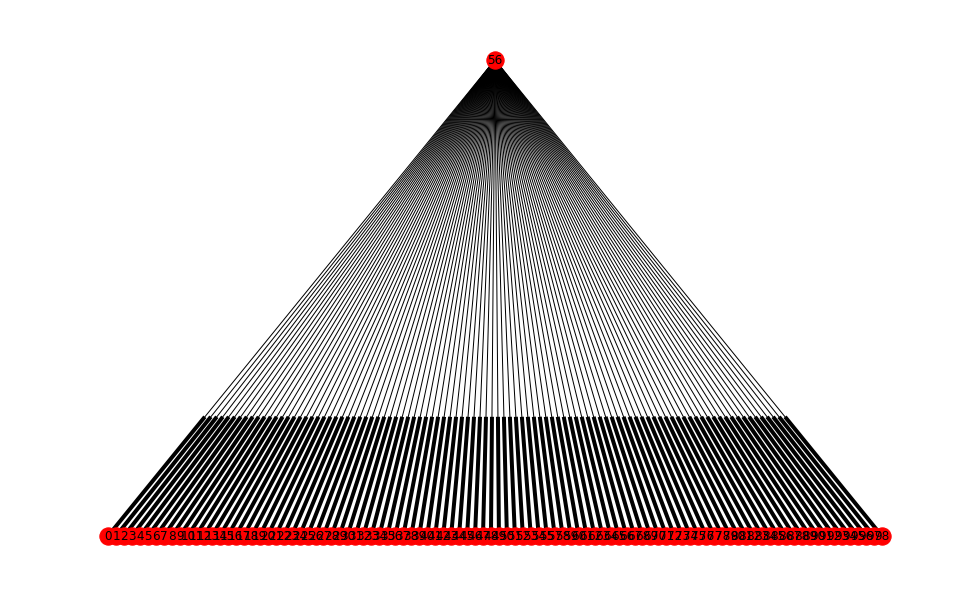

In [33]:

pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
print(pos)
plt.figure(figsize=(13,8))
nx.draw(G, pos, with_labels=True, k=1)
plt.show()
plt.savefig('test.png')

In [35]:
X_train_articles = np.delete(X_train_articles,56, axis=1)
X_train_headlines = np.delete(X_train_headlines,56, axis=1)

In [38]:
model = BayesianNetwork.from_samples(X_train_articles[:600],root=55)
print model.structure

((55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,), (55,))


In [37]:
G = nx.DiGraph()
for i in range(len(model.structure)):
    for j in range(len(model.structure)):
        if len(model.structure[j]) == 0:
            continue
        if model.structure[j][0] == i:
            G.add_edge(i,j)

In [5]:
%pylab inline


X = np.random.randint(2, size=(2000, 7))
X[:,3] = X[:,1]
X[:,6] = X[:,1]

X[:,0] = X[:,2]

X[:,4] = X[:,5]

model = BayesianNetwork.from_samples(X, algorithm='exact')
print model.structure


Populating the interactive namespace from numpy and matplotlib
((), (3,), (0,), (), (), (4,), (1,))


In [67]:
model.graph.plot()

IOError: [Errno 13] Permission denied: 'c:\\users\\jake\\appdata\\local\\temp\\tmpo4yt2g'